In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import copy
from pyDOE2 import lhs

T_START = 0
T_S = 0.5
T_END = 10.5

NUM_EPOCHS = 3000
LEARNING_RATE = 1e-4
NUM_POINTS = 1000
NUM_COLLOCATION = 100000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

In [ ]:
def u(t):
    return 0.45

# Define the Van der Pol oscillator ODEs
def vdp_odes(x, t, mu):
    x1, x2 = x
    dx1dt = x2
    dx2dt = mu * (1 - x1**2) * x2 - x1 + u(t)
    return [dx1dt, dx2dt]


# Set the initial conditions
y0 = [-2, 1]
mu = 1
t = np.linspace(T_START, T_END, 25)

# Solve the ODEs
sol = odeint(vdp_odes, y0, t, args=(mu,))

# Plotting the results
plt.figure(figsize=(10, 3))
plt.plot(t, sol[:, 0], marker="o", markersize=3, label="x1(t)")
plt.plot(t, sol[:, 1], marker="o", markersize=3, label="x2(t)")
plt.title("Van der Pol Oscillator")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Generate a dataset
def generate_uniform(num_points: int) -> pd.DataFrame:
    df = pd.DataFrame(columns=["t", "x1", "x2", "u"])
    df["x1"] = np.random.uniform(-3, 3, num_points)
    df["x2"] = np.random.uniform(-3, 3, num_points)
    df["u"] = np.random.uniform(-1, 1, num_points)
    df["t"] = 0.0
    return df

def generate_lhs(x1_range: list, x2_range: list, u_range: list, t_range: list, num_points: int) -> pd.DataFrame:
    # Use LHS to generate samples in the unit interval [0, 1]
    lhs_samples = lhs(4, samples=NUM_POINTS)  # 3 dimensions: x1, x2, u
    # Scale the samples to the desired ranges
    x1_samples = x1_range[0] + (x1_range[1] - x1_range[0]) * lhs_samples[:, 0]
    x2_samples = x2_range[0] + (x2_range[1] - x2_range[0]) * lhs_samples[:, 1]
    u_samples = u_range[0] + (u_range[1] - u_range[0]) * lhs_samples[:, 2]
    t_samples = t_range[0] + (t_range[1] - t_range[0]) * lhs_samples[:, 3]
    # Combine the results
    df = pd.DataFrame({"t": t_samples, "x1": x1_samples, "x2": x2_samples, "u": u_samples})  
    return df

# df = generate_uniform(NUM_POINTS)
df = generate_lhs(x1_range=[-3,3], x2_range=[-3,3], u_range=[-1,1], t_range=[0,0], num_points=NUM_POINTS)
print(f"Dataset shape: {df.shape}")

In [ ]:
def np_to_ts(x):
    return (
        torch.tensor(x, dtype=torch.float32, requires_grad=True).view(-1, 1).to(DEVICE)
    )

def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x


def loss_fn(net: PINN, X_train: torch.Tensor):
    df_col = generate_lhs(x1_range=[-3,3], x2_range=[-3,3], u_range=[-1,1], t_range=[0,T_S], num_points=NUM_COLLOCATION)
    t_col = np_to_ts(df_col["t"].values).to(DEVICE)
    x1_col = np_to_ts(df_col["x1"].values).to(DEVICE)
    x2_col = np_to_ts(df_col["x2"].values).to(DEVICE)
    u_col = np_to_ts(df_col["u"].values).to(DEVICE)
    
    X_col = torch.cat((t_col, x1_col, x2_col, u_col), 1).to(DEVICE)

    preds = net.forward(X_col)

    x1_pred = preds[:, 0].view(-1, 1)
    x2_pred = preds[:, 1].view(-1, 1)

    dx1dt = grad(x1_pred, t_col)[0]
    dx2dt = grad(x2_pred, t_col)[0]

    error_dx1dt = nn.MSELoss()(dx1dt, x2_pred)
    error_dx2dt = nn.MSELoss()(dx2dt, mu * (1 - x1_pred**2) * x2_pred - x1_pred + u_col)

    error_ode = error_dx1dt + error_dx2dt

    return error_ode

In [ ]:
t_train = np_to_ts(df["t"].values)
x1_train = np_to_ts(df["x1"].values)
x2_train = np_to_ts(df["x2"].values)
u_train = np_to_ts(df["u"].values)

X_train = torch.cat([t_train, x1_train, x2_train, u_train], dim=1)
y_train = torch.cat([x1_train, x2_train], dim=1)

In [67]:
net = PINN(4, 2).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Loss weights
w_data, w_ode, w_ic = 1, 1, 1

# Initialize early stopping variables
best_loss = float("inf")
best_model_weights = None
patience = PATIENCE
threshold = THRESHOLD

for epoch in range(NUM_EPOCHS):
    optimizer.zero_grad()
    preds = net.forward(X_train)

    loss_data = nn.MSELoss()(preds, y_train)

    loss_ode = loss_fn(net, X_train)

    loss = w_data * loss_data + w_ode * loss_ode
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}, Loss_data: {loss_data.item():.4f}, Loss_ode: {loss_ode.item():.4f}"
        )

    if epoch >= EARLY_STOPPING_EPOCH:
        if loss < best_loss - threshold:
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 1000
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")
                net.load_state_dict(best_model_weights)
                break

Epoch 300, Loss_data: 1.6932, Loss_ode: 0.5189
Epoch 400, Loss_data: 1.6179, Loss_ode: 0.4924
Epoch 500, Loss_data: 1.5704, Loss_ode: 0.4982
Epoch 600, Loss_data: 1.5214, Loss_ode: 0.4801
Epoch 700, Loss_data: 1.4608, Loss_ode: 0.4960
Epoch 800, Loss_data: 1.3722, Loss_ode: 0.4752
Epoch 900, Loss_data: 1.2689, Loss_ode: 0.4400
Epoch 1000, Loss_data: 1.1213, Loss_ode: 0.4290
Epoch 1100, Loss_data: 0.9707, Loss_ode: 0.3981
Epoch 1200, Loss_data: 0.8294, Loss_ode: 0.3494
Epoch 1300, Loss_data: 0.7170, Loss_ode: 0.3364
Epoch 1400, Loss_data: 0.6274, Loss_ode: 0.3233
Epoch 1500, Loss_data: 0.5615, Loss_ode: 0.3018
Epoch 1600, Loss_data: 0.5133, Loss_ode: 0.3104
Epoch 1700, Loss_data: 0.4822, Loss_ode: 0.2686
Epoch 1800, Loss_data: 0.4503, Loss_ode: 0.2700
Epoch 1900, Loss_data: 0.4243, Loss_ode: 0.2588
Epoch 2000, Loss_data: 0.4107, Loss_ode: 0.2320
Epoch 2100, Loss_data: 0.3899, Loss_ode: 0.2299
Epoch 2200, Loss_data: 0.3732, Loss_ode: 0.2226
Epoch 2300, Loss_data: 0.3593, Loss_ode: 0.2241

### Autoregression

In [68]:
# Create validation set
t_val = t.copy()
T_s = t_val[1]  # Sampling time
x1_val = sol[:, 0].copy()
x2_val = sol[:, 1].copy()
u_val = [0.45 for _ in range(len(t_val))]
X_val = torch.tensor(
    np.array([t_val, x1_val, x2_val, u_val]).T, dtype=torch.float32
).to(DEVICE)
y_val = torch.tensor(np.array([x1_val, x2_val]).T, dtype=torch.float32).to(DEVICE)

In [69]:
x1_0 = x1_val[0]
x2_0 = x2_val[0]
u_0 = u_val[0]

x1_preds = []
x2_preds = []
for i in range(1, len(t_val)):
    y_k = net.forward(
        torch.tensor([T_s, x1_0, x2_0, 0.45], dtype=torch.float32).to(DEVICE)
    )
    # x1_0 = y_k[0].item()
    # x2_0 = y_k[1].item()
    x1_0 = x1_val[i]  # Yeah! Control
    x2_0 = x2_val[i]  # Yeah! Control
    x1_preds.append(y_k[0].item())
    x2_preds.append(y_k[1].item())

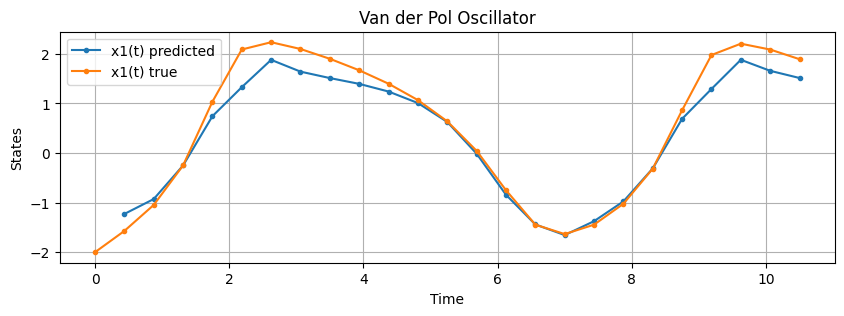

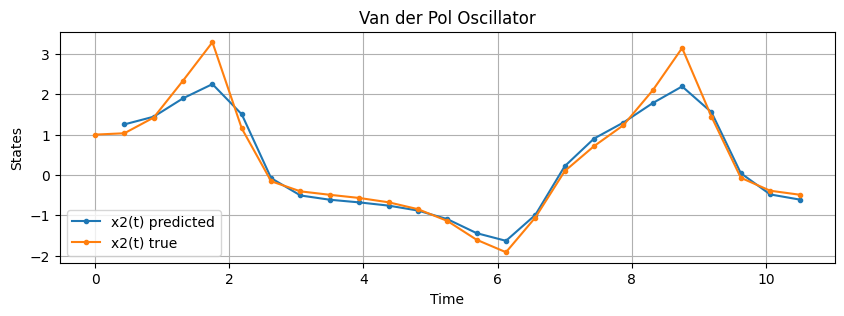

In [70]:
# Plot x1_preds
plt.figure(figsize=(10, 3))
plt.plot(t_val[1:], x1_preds, marker="o", markersize=3, label="x1(t) predicted")
plt.plot(t_val, x1_val, marker="o", markersize=3, label="x1(t) true")
plt.title("Van der Pol Oscillator")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

# Plot x2_preds
plt.figure(figsize=(10, 3))
plt.plot(t_val[1:], x2_preds, marker="o", markersize=3, label="x2(t) predicted")
plt.plot(t_val, x2_val, marker="o", markersize=3, label="x2(t) true")
plt.title("Van der Pol Oscillator")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

# Control

In [71]:
from scipy.optimize import minimize
from tqdm import tqdm

In [120]:
def predictive_model(x1: float, x2: float, u: float) -> tuple:
    y_k = net.forward(torch.tensor([T_s, x1, x2, u], dtype=torch.float32).to(DEVICE))
    x_1 = y_k[0].item()
    x_2 = y_k[1].item()
    return x_1, x_2

In [126]:
x1 = 0.0
x2 = 0.0
Np = 5
Nc = 5
x1_seq = []
x2_seq = []
u_seq = []

SP = 1.0
rho = 0.05

def cost_function(u_seq, x1_0, x2_0, t):
    x1_pred = x1_0
    x2_pred = x2_0
    J = 0.0
    # SP_dynamic = np.clip(t / 5 * SP, 0, SP)  # Gradual ramp of setpoint
    SP_dynamic = SP 
    for j in range(Np):
        u = u_seq[min(j, Nc - 1)]
        x1_pred, x2_pred = predictive_model(x1_pred, x2_pred, u_seq[j])
        if j > 0:
            J += (x1_pred - SP_dynamic) ** 2 + rho * (u - u_seq[j - 1]) ** 2
        else:
            J += (x1_pred - SP_dynamic) ** 2
    return J
    
def mpc_control(x1, x2, t):
    u_init = np.random.uniform(-1, 1, Np)
    results = minimize(cost_function, u_init, args=(x1, x2, t), bounds=[(-1.0, 1.0)] * Np)
    return results.x[0] if results.success else 0.0
    
for t in tqdm(range(len(t_val))):
    u_opt = mpc_control(x1_0, x2_0, t * T_s)
    u_seq.append(u_opt)
    x1_seq.append(x1)
    x2_seq.append(x2)
    x1, x2 = predictive_model(x1, x2, u_opt)

100%|██████████| 25/25 [00:05<00:00,  4.73it/s]


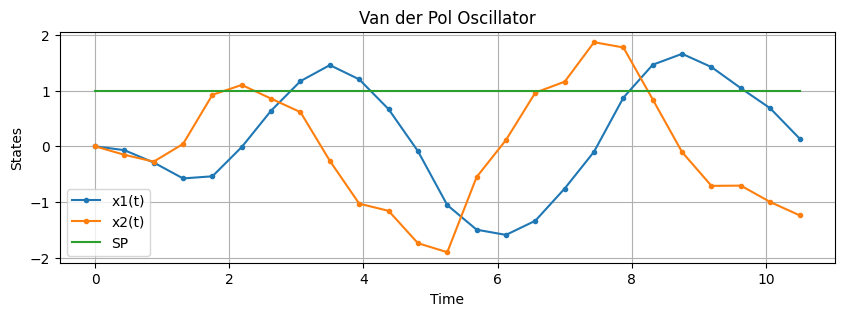

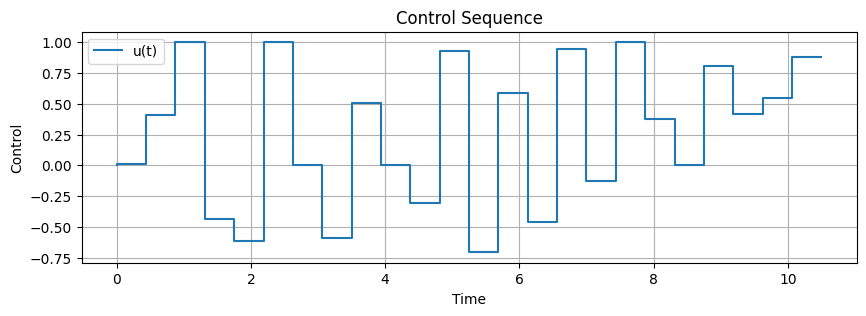

In [127]:
# Plot results
plt.figure(figsize=(10, 3))
plt.plot(t_val, x1_seq, marker="o", markersize=3, label="x1(t)")
plt.plot(t_val, x2_seq, marker="o", markersize=3, label="x2(t)")
plt.plot(t_val, [SP for _ in range(len(t_val))], label="SP")
plt.title("Van der Pol Oscillator")
plt.xlabel("Time")
plt.ylabel("States")
plt.legend()
plt.grid(True)
plt.show()

# Plot control sequence
plt.figure(figsize=(10, 3))
plt.step(t_val, u_seq, label="u(t)")
plt.title("Control Sequence")
plt.xlabel("Time")
plt.ylabel("Control")
plt.legend()
plt.grid(True)
plt.show()